## Deep Shutdown Benchmark Test

### 1) Load evaluation environment

In [1]:
import warnings
import os
from gridgym.envs.grid_env import GridEnv
from datetime import datetime
from shutil import copyfile
from gridgym.envs.off_reservation_env import OffReservationEnv

warnings.filterwarnings('ignore')

cluster = 'lyon'

# Define variables
train_log = "../weights/ppo_log.csv"
test_workloads =  cluster + "/workloads/test/"
train_workloads =  cluster + "/workloads/train/"
output_dir =  cluster + "/results/"
platform_fn = cluster + "/platform.xml"
deepshutdown_model = "../weights/checkpoints/taurus"
simulator_path = "../src/"
env_id = 'OffReservation-v0'
deepshutdown_repeat = 5
timeout_policies = [1, 10]
seed = 48238

GridEnv.OUTPUT= os.path.join(simulator_path, GridEnv.OUTPUT)
GridEnv.PLATFORM= os.path.join(simulator_path, GridEnv.PLATFORM)
GridEnv.WORKLOADS= os.path.join(simulator_path, GridEnv.WORKLOADS)
OffReservationEnv.TRACE = True

In [2]:
# Load platform/model
from src import deepshutdown as launcher
def load_platform(fn):
    simulator_platform = os.path.join(simulator_path, GridEnv.PLATFORM)
    copyfile(fn, simulator_platform)
    
def load_deepshutdown(weights, env_id):
    import sys
    argv_tmp, sys.argv = sys.argv, [sys.argv[0]]  # workaround to get default model parameters from launcher.
    args = launcher.parse_args()
    sys.argv = argv_tmp
    env = launcher.build_env(args.env_id, 1, args.nb_frames)
    input_shape, nb_actions = env.observation_space.shape, env.action_space.n
    agent = launcher.get_agent(input_shape, nb_actions, 1, seed, args.nb_frames, 1, 1, 1, 1, None)
    agent.load(weights)
    return agent, args.nb_frames

load_platform(platform_fn)
deep_shutdown, nb_frames = load_deepshutdown(deepshutdown_model, env_id)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
Use tf.random.categorical instead.
Instructions for updating:
Use tf.cast instead.
 [*] Loading variables...
 [*] Variables loaded successfully


### 3) Run tests

#### 3.1) Prepare

In [3]:
import gym
import gridgym.envs.grid_env as g
import pandas as pd
import numpy as np
from gridgym.envs.simulator.utils.graphics import plot_simulation_graphics
from collections import defaultdict
from shutil import rmtree
from tqdm import tqdm_notebook as tqdm
from src.agents.timeout import TimeoutAgent  

import matplotlib.pyplot as plt


def get_workloads(path):
    return [os.path.join(path, w) for w in os.listdir(path) if w.endswith('.json')]

def load_workload(src, dest):
    rmtree(dest)
    os.makedirs(dest)
    fn = os.path.split(src)[-1]
    copyfile(src, os.path.join(dest, fn))

def run_deepshutdown(env_id, agent):
    env = launcher.build_env(env_id, 1, nb_frames)
    r = agent.play(env)
    r['policy'] = 'DeepShutdown'
    return r

def run_timeout(env_id, timeout):    
    env = gym.make(env_id)
    nb_resources = env.observation_space.spaces['platform'].shape[0] * env.observation_space.spaces['platform'].shape[1]
    nb_nodes = env.observation_space.spaces['platform'].shape[0]
    agent = TimeoutAgent(timeout, nb_resources, nb_nodes)
    results = agent.play(env)
    results['policy'] = "Timeout ({})".format(timeout)
    return results

def run_experiment(workloads):
    bench_results = defaultdict(list)
    simulator_workload = os.path.join(simulator_path, GridEnv.WORKLOADS)
    
    for _ in tqdm(range(4), desc="DeepShutdown Experiments"):
        for workload in tqdm(workloads, desc='Workloads', leave=False):
            w_name = workload[workload.rfind('_')+1:workload.rfind('.json')]
            load_workload(workload, simulator_workload)
            results = run_deepshutdown(env_id, deep_shutdown)
            results['week'] = w_name
            for k, v in results.items():
                bench_results[k].append(v)
            #f = plot_simulation_graphics(results['trace'][-1]['jobs'],results['trace'][-1]['host_states'],results['trace'][-1]['host_pstates'],results['trace'][-1]['consumed_energy'],show=False)
            #plt.close()
            #f.savefig(os.path.join(output_dir, 'deepshutdown_{}.png'.format(results['workload'][-1])))
    for workload in tqdm(workloads, desc='Timeout Experiments', leave=True):
        load_workload(workload, simulator_workload)
        w_name = workload[workload.rfind('_')+1:workload.rfind('.json')]
        # Run Timeout Experiments
        for timeout in tqdm(timeout_policies, desc='Timeout', leave=False):
            results = run_timeout(env_id, timeout)
            results['week'] = w_name
            for k, v in results.items():
                bench_results[k].append(v)
            #f = plot_simulation_graphics(results['trace']['jobs'],results['trace']['host_states'],results['trace']['host_pstates'],results['trace']['consumed_energy'],show=False)
            #plt.close()
            #f.savefig(os.path.join(output_dir, '{}_{}.png'.format(timeout, results['workload'])))
    return bench_results    

#### Test with Train Data

In [4]:
train_results = run_experiment(get_workloads(train_workloads))
train_results = pd.DataFrame(train_results)
if output_dir:
    out_dir = os.path.join(output_dir, 'train/')
    os.makedirs(out_dir, exist_ok=True)
    train_results.to_csv(os.path.join(out_dir, "benchmark.csv"), index=False)  
train_results.set_index(train_results['week'], inplace=True)
train_results.index.name = "week"

#### Test with Test Data

In [9]:
test_results = run_experiment(get_workloads(test_workloads))
test_results = pd.DataFrame(test_results)
if output_dir:
    out_dir = os.path.join(output_dir, 'test/')
    os.makedirs(out_dir, exist_ok=True)
    test_results.to_csv(os.path.join(out_dir, "benchmark.csv"), index=False)  
test_results.set_index(test_results['week'], inplace=True)
test_results.index.name = "week"

### 4) Plot Results

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from datetime import datetime
from bokeh.layouts import gridplot
from math import radians
from bokeh.models.tickers import FixedTicker, DatetimeTicker, SingleIntervalTicker
from bokeh.models.formatters import DatetimeTickFormatter
from bokeh.models import ColumnDataSource, Range1d, DatetimeAxis
from bokeh.palettes import mpl
from bokeh.io import export_png
from bokeh.models import Band, ColumnDataSource, Whisker
from bokeh.plotting import figure, show, output_notebook, output_file

output_notebook()


#test_results = pd.read_csv(os.path.join(output_dir + "test/", "benchmark.csv"))
#test_results.set_index(test_results['week'], inplace=True)
#test_results.index.name = "week"
#train_results = pd.read_csv(os.path.join(output_dir + "train/", "benchmark.csv"))
#train_results.set_index(train_results['week'], inplace=True)
#train_results.index.name = "week"

colors = mpl['Plasma'][5]
def compare(df, metric, ylabel, showx=True, legnd=True, compare=True, scale=1):
    grouped = df.groupby([df.index, df.policy]).aggregate([np.mean, np.std]).unstack()[metric].sort_index()
    grouped /= scale
    #x = np.array(grouped.index, dtype=np.datetime64)
    x = list(range(0, len(grouped.index)))
    fig = figure(toolbar_location="below", tools='', x_range=(x[0], x[-1] + 0.5), width=900, height=250, x_axis_label='week', y_axis_label=ylabel)
    std = grouped['std']['DeepShutdown']
    fig.line(x, grouped['mean']['DeepShutdown'], legend='DeepShutdown', line_color=colors[0], line_width=1)
    fig.square(x, grouped['mean']['DeepShutdown'], legend='DeepShutdown', line_color=colors[0], fill_color=colors[0], line_width=2)
    if compare:
        fig.line(x, grouped['mean']['Timeout (1)'], legend='Timeout (1)', line_color=colors[3], line_width=1)
        fig.diamond(x, grouped['mean']['Timeout (1)'], legend='Timeout (1)', line_color=colors[3], fill_color=colors[3], line_width=2)
        fig.line(x, grouped['mean']['Timeout (10)'], legend='Timeout (10)', line_color=colors[1], line_width=1)
        fig.circle(x, grouped['mean']['Timeout (10)'], legend='Timeout (10)', line_color=colors[1], fill_color=colors[1], line_width=2)
        #fig.line(x, grouped['mean']['Timeout (10)'], legend='Timeout (10)', line_color=colors[2], line_width=1)
        #fig.triangle(x, grouped['mean']['Timeout (10)'], legend='Timeout (10)', line_color=colors[2], fill_color=colors[2], line_width=2)
         
    errors = ColumnDataSource({
        'upper':grouped['mean']['DeepShutdown'] + std, 
        'lower': grouped['mean']['DeepShutdown'] - std, 
        'base':x})
    fig.add_layout(Whisker(source=errors, base='base', upper='upper', lower='lower'))
    #band = Band(base='base', lower='lower', upper='upper', source=errors, level='underlay', fill_alpha=0.05, line_width=1, line_color=colors[0], fill_color=colors[0])
    #fig.add_layout(band)
    
    fig.grid.grid_line_alpha = 0
    fig.xaxis.ticker = SingleIntervalTicker(interval=1)
    fig.legend.orientation = "horizontal"
    fig.legend.location = "top_center"
    fig.xaxis.minor_tick_line_color = None  # turn off x-axis minor ticks
    fig.yaxis.minor_tick_line_color = None  # turn off y-axis minor ticks
    fig.xaxis.visible = showx
    fig.legend.visible = legnd
    return fig


Loading BokehJS ...

#### Plot Learning

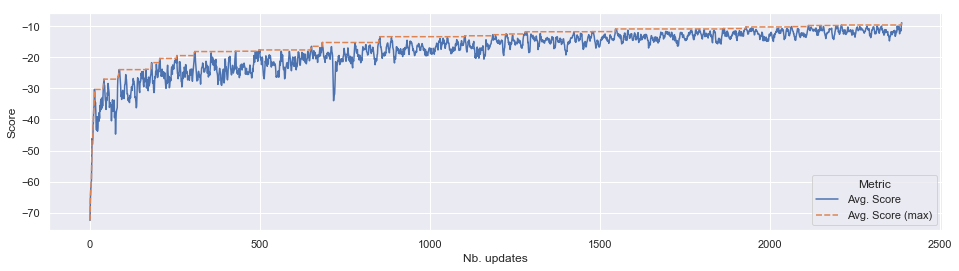

In [6]:
import seaborn as sns
import pandas as pd
sns.set()
f, ax = plt.subplots(figsize=(16,4)) 
log = pd.read_csv(train_log)
log = pd.melt(log, id_vars='nupdates', value_vars=['eprew_avg', 'eprew_avg_max'], var_name='Metric')
sns.lineplot(x='nupdates', y='value', hue='Metric', style='Metric', data=log, ax=ax, legend=False)
ax.set(ylabel='Score', xlabel='Nb. updates')
ax.legend(labels=['Avg. Score', 'Avg. Score (max)'], title='Metric')

#### Plot Train Results

In [7]:
p4= compare(train_results,'mean_stretch', 'Average stretch (min)', legnd=False)
p3 = compare(train_results,'score', 'Score', legnd=False, showx=False)
p2 = compare(train_results,'energy_waste', 'Energy wasted (J x Million)', legnd=False, showx=False, scale=1000000)
p1 = compare(train_results,'nb_switches', 'Nb. of state switches', showx=False)
fig = gridplot([[p1], [p2], [p3], [p4]])
#export_png(fig, os.path.join(output_dir, 'train_results.png'))
show(fig)

In [8]:
x = train_results.groupby(['policy'], as_index=False).mean()
x = x[['policy', 'score', 'mean_stretch', 'nb_switches', 'energy_waste']]
x['score_perc'] = x['score'] / x['score'].min()
x['mean_stretch_perc'] = x['mean_stretch'] / x['mean_stretch'].max()
x['nb_switches_perc'] = x['nb_switches'] / x['nb_switches'].max()
x['energy_waste_perc'] = x['energy_waste'] / x['energy_waste'].max()
x

,policy,score,mean_stretch,nb_switches,energy_waste,score_perc,mean_stretch_perc,nb_switches_perc,energy_waste_perc
0,DeepShutdown,-11.344548,0.174790,75.088542,329516.385417,0.290611,1.000000,0.406067,0.352105
1,Timeout (1),-24.039179,0.047834,184.916667,624833.479167,0.615807,0.273666,1.000000,0.667666
2,Timeout (10),-39.036893,0.040521,103.333333,935846.937500,1.000000,0.231827,0.558810,1.000000


#### Plot Test Results

In [10]:
p4= compare(test_results, 'mean_stretch', 'Average stretch (min)', legnd=False)
p3 = compare(test_results,'score', 'Score', legnd=False, showx=False)
p2 = compare(test_results,'energy_waste', 'Energy wasted (J x Million)', legnd=False, showx=False, scale=1000000)
p1 = compare(test_results,'nb_switches', 'Nb. of state switches', showx=False)
fig = gridplot([[p1], [p2], [p3], [p4]])
export_png(fig, os.path.join(output_dir, 'test_results.png'))
show(fig)

In [11]:
x = test_results.groupby(['policy'], as_index=False).mean()
x = x[['policy', 'score', 'mean_stretch', 'nb_switches', 'energy_waste']]
x['score_perc'] = x['score'] / x['score'].min()
x['mean_stretch_perc'] = x['mean_stretch'] / x['mean_stretch'].max()
x['nb_switches_perc'] = x['nb_switches'] / x['nb_switches'].max()
x['energy_waste_perc'] = x['energy_waste'] / x['energy_waste'].max()
x

,policy,score,mean_stretch,nb_switches,energy_waste,score_perc,mean_stretch_perc,nb_switches_perc,energy_waste_perc
0,DeepShutdown,-10.147909,0.105293,73.409091,229642.000000,0.363136,1.000000,0.513024,0.378912
1,Timeout (1),-17.774390,0.018358,143.090909,392469.454545,0.636045,0.174349,1.000000,0.647579
2,Timeout (10),-27.945195,0.012714,71.454545,606056.363636,1.000000,0.120753,0.499365,1.000000


### 5) Analyse the policy learned by DeepShutdown

In [42]:
import pandas as pd

history = pd.read_csv("lyon/results/history.csv")
history = history[~((history.queue_sz == 0) & (history.reservation == 0))]

#clusters = pd.read_csv("lyon/lyon_clusters.csv")
#cluster_util = clusters.groupby('cluster', as_index=False).mean()
#bins = [0, 5., 25., 50., 75., 100.]
#group_names = ["5 %", "25 %", "50 %", "75 %", "100 %"]
#clusters['utilization_binned'] = pd.cut(clusters['utilization'], bins, labels=group_names, include_lowest=True)
#clusters = clusters.groupby('cluster').first()
#history['cluster_util'] = history['cluster'].apply(lambda c: clusters.iloc[c]['utilization_binned'])

#### 5.1) Reservation size frequency per workload utilisation

NameError: name 'history' is not defined

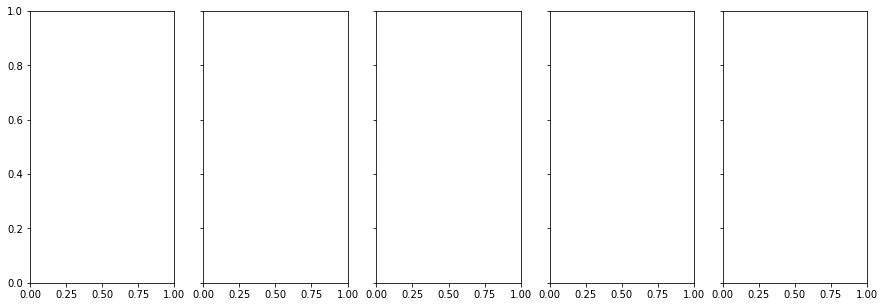

In [83]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(1, 5, figsize=(15,5), sharey=True, sharex=False, clear=True)

plot_order = {'5 %': 0, '25 %': 1, '50 %': 2, '75 %': 3, '100 %': 4}

for a, b in history.groupby('cluster_util'):
    x = b.groupby('reservation').size()
    x /= x.sum()
    ax[plot_order[a]].set_title(a)
    ax[plot_order[a]].bar(x=np.arange(0, 15), height=x, width=1, align='edge', edgecolor='black')
    ax[plot_order[a]].set_xlim([-0, 15])
    ax[plot_order[a]].set_xticks(np.arange(0, 15)+.5, minor=False)
    ax[plot_order[a]].set_xticklabels([str(a) for a in np.arange(0, 15)], minor=False)
    ax[plot_order[a]].set_ylim([0, 0.7])
    ax[plot_order[a]].grid(axis='y')

ax[0].set_ylabel("Frequency")
ax[2].set_xlabel("Reservation size")
plt.tight_layout()

plt.savefig(os.path.join(output_dir, 'reservation_freq.png'))


#### 5.2) Reservation size vs Queue size

56477.0


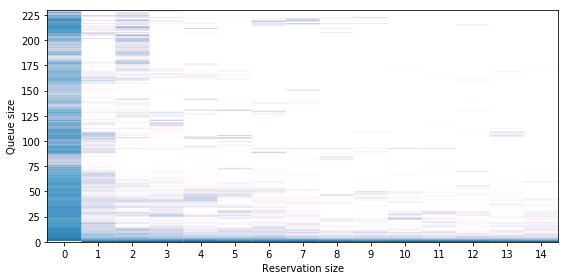

In [106]:

import matplotlib.colors as colors
grouped =history.groupby(['queue_sz', 'reservation']).size().unstack().fillna(0)
print(np.max(grouped.max()))
fig, ax = plt.subplots(figsize=(8,4))
im = ax.pcolor(grouped, edgecolors=None, cmap='PuBu', norm=colors.LogNorm(vmin=1+np.min(grouped.min()), vmax=np.max(grouped.max())))
               
ax.set_xticks(np.arange(0, 15)+.5, minor=False)
ax.set_xticklabels([str(a) for a in np.arange(0, 15)], minor=False)
ax.set_yticks(np.arange(0, grouped.shape[0]+1, 25), minor=False)
ax.set_xlabel("Reservation size")
ax.set_ylabel("Queue size")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'normalized_reservation_per_queue.png'))

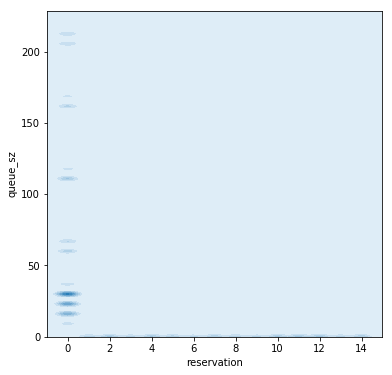

In [105]:
import seaborn as sns
f, ax = plt.subplots(figsize=(6, 6))
#cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=False)
sns.kdeplot(history.reservation, history.queue_sz, shade=True);

#### 4.1) ANOVA   

In [103]:
#fig, ax = plt.subplots()
grouped = bench_results.groupby([bench_results.index, bench_results.policy]).reward.apply(np.mean).unstack()

print(stats.f_oneway(grouped['DeepShutdown'], grouped['idle_5']))
print(stats.f_oneway(grouped['DeepShutdown'], grouped['idle_10']))
print(stats.f_oneway(grouped['DeepShutdown'], grouped['idle_15']))

F_onewayResult(statistic=21.46025640351677, pvalue=1.0500722183321777e-05)
F_onewayResult(statistic=65.99968357968736, pvalue=9.863426074777389e-13)
F_onewayResult(statistic=110.67840849562002, pvalue=4.6260566079517584e-18)


In [82]:
import json

with open('clrlcgce02/workloads/temp/2006-03-05.json') as f:
    workload = json.load(f)
    all_jobs = workload['jobs']
    for i in range(1, 8):
        workload['jobs'] = []
        while True and all_jobs:
            job = all_jobs[0]
            if job['subtime'] < 1440 * i:
                job['subtime'] -= 1440 * (i - 1)
                workload['jobs'].append(job)
                del all_jobs[0]
            else:
                break
        workload['nb_jobs'] = len(workload['jobs'])
        if workload['jobs']:
            workload['max_walltime'] = max(j['walltime'] for j in workload['jobs'])
            workload['load'] = sum((workload['profiles'][j['profile']]['cpu'] / 1000000.) * j['res'] for j in workload['jobs']) / (1440 * 168.)
            with open('clrlcgce02/workloads/temp/day_{}.json'.format(i), 'w') as ou:
                json.dump(workload, ou)
                                
        
